In [5]:
import numpy as np
import tensorflow as tf
import math, os, sys

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [235]:
dataset = np.load('dataset/stock_dataset_preprocessed.npz')
features, labels = dataset['features'][:, :, :4].astype('float32'), dataset['labels'].astype('float32')
input_shape = features.shape
train_test_split_factor = .8
validation_split_factor = .2
train_x, train_y, test_x, test_y = features[:math.floor(len(features)*train_test_split_factor)], labels[:math.floor(len(labels)*train_test_split_factor)], features[math.floor(len(features)*train_test_split_factor):], labels[math.floor(len(labels)*train_test_split_factor):]
train_x, test_x = np.expand_dims(train_x, axis=1), np.expand_dims(test_x, axis=1) # for use with TimeDistributed
#train_y, test_y = np.expand_dims(train_y, axis=1), np.expand_dims(test_y, axis=1) # for use with TimeDistributed
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(288, 1, 7, 4) (288, 7) (72, 1, 7, 4) (72, 7)


In [236]:
#layers = [
#    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='linear', input_shape=input_shape[1:])),
#    tf.keras.layers.Reshape((1, 7))
#]
layers = [
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(7, 3, padding='same', activation='relu', input_shape=input_shape[1:])),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(7, 3, padding='same', activation='relu', dilation_rate=2)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(14, 3, padding='same', activation='relu', dilation_rate=1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(36, 3, padding='same', activation='relu', dilation_rate=1)),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation='linear')
]
model = tf.keras.models.Sequential(layers=layers)
#model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy', tf.keras.metrics.MeanSquaredError()])
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
#model.summary()

In [237]:
graph = model.fit(train_x, train_y, validation_split=validation_split_factor, epochs=250)
model.summary()

Epoch 1/250
8/8 [==============================] - 0s 28ms/step - loss: 1061866.3750 - accuracy: 0.1261 - val_loss: 68666.9766 - val_accuracy: 0.0345
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 1055002.7500 - accuracy: 0.1261 - val_loss: 67860.5859 - val_accuracy: 0.0345
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 1038893.6875 - accuracy: 0.1261 - val_loss: 65905.5469 - val_accuracy: 0.0345
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 998782.3125 - accuracy: 0.1261 - val_loss: 60898.9531 - val_accuracy: 0.0345
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 880656.5000 - accuracy: 0.1435 - val_loss: 49323.3164 - val_accuracy: 0.1552
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 653866.6250 - accuracy: 0.0783 - val_loss: 25524.7227 - val_accuracy: 0.1552
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 258183.7500 - accuracy: 0.0783 - val_

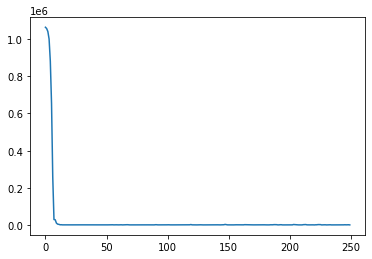

In [238]:
import matplotlib.pyplot as plt
loss = graph.history['loss']
val_loss = graph.history['val_loss']
val_acc = graph.history['val_accuracy']
plt.plot(range(len(loss)), loss)

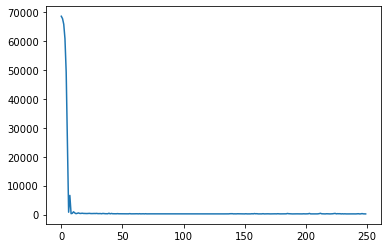

In [239]:
plt.plot(range(len(val_loss)), val_loss)

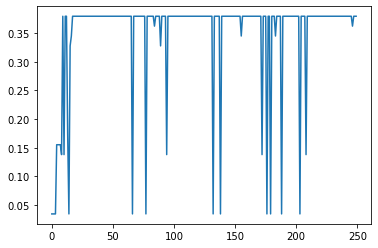

In [240]:
plt.plot(range(len(val_acc)), val_acc)

In [241]:
model.evaluate(test_x, test_y)

3/3 [==============================] - 0s 3ms/step - loss: 411.1826 - accuracy: 0.3889


[411.1826171875, 0.3888888955116272]

In [242]:
pred = model.predict(test_x)

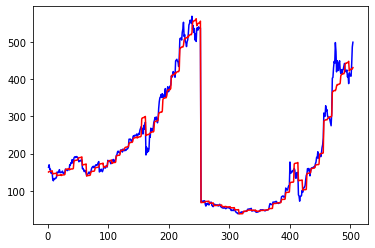

In [243]:
close_pred = np.reshape(pred, (-1, 1))
test_y_reshape = np.reshape(test_y, (-1, 1))
days = np.arange(1, len(test_y_reshape)+1)
plt.plot(days, test_y_reshape, 'b', days, close_pred, 'r')

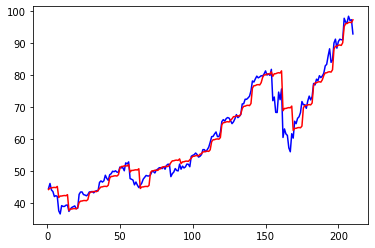

In [245]:
pred = model.predict(train_x[:30, :, :, :])
close_pred = np.reshape(pred, (-1, 1))
test_y_reshape = np.reshape(train_y[:30, :], (-1, 1))
days = np.arange(1, len(test_y_reshape)+1)
plt.plot(days, test_y_reshape, 'b', days, close_pred, 'r')

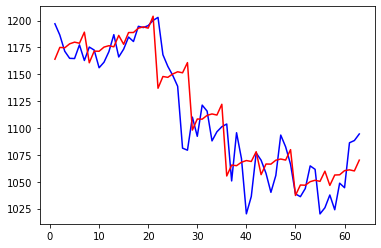

In [246]:
test_dataset = np.load('dataset/test_stock_preprocessed.npz')
test_stock_x, test_stock_y = test_dataset['features'][:, :, :4], test_dataset['labels']
test_stock_x = np.expand_dims(test_stock_x, axis=1)
pred = model.predict(test_stock_x)
close_pred = np.reshape(pred, (-1, 1))
test_y_reshape = np.reshape(test_stock_y, (-1, 1))
days = np.arange(1, len(test_y_reshape)+1)
plt.plot(days, test_y_reshape, 'b', days, close_pred, 'r')